# Evolutionary Computation Assignment 8 – Global Convexity

- Vadym Repetskyi 155610
- Krzysztof Szala 144571


In [3]:
from utils import TspInstance, random_solution, local_search
import numpy as np
import matplotlib.pyplot as plt

tsp_a = TspInstance("TSPA.csv")
tsp_b = TspInstance("TSPB.csv")

## Greedy local search with edge exchange and cost delta optimization

```python
def local_search(tsp, solution):
    if solution is None:
        solution = random_solution(tsp)

    while True:
        # Alter the order of inter and intra move evaluation randomly

        delta_inter, *move_inter = find_improving_inter(tsp, solution)

        if delta_inter < 0:
            apply_move(solution, *move_inter)
            continue

        delta_intra, *move_intra = find_improving_intra(tsp, solution)

        if delta_intra < 0:
            apply_move(solution, *move_intra)
            continue

        return solution


def find_improving_inter(tsp, solution):
    node_a is one of the nodes in the solution
    node_b is one of the nodes not in the solution

    for each combination of node_a and node_b:
        node_prev = solution[index_a - 1]
        node_next = solution[index_a + 1]

        delta = (
                tsp.node_costs[node_b]
                + tsp.distance_matrix[node_prev, node_b]
                + tsp.distance_matrix[node_b, node_next]
                - tsp.node_costs[node_a]
                - tsp.distance_matrix[node_prev, node_a]
                - tsp.distance_matrix[node_a, node_next]
            )

        if delta < 0:
            return [delta, "inter", node_a, node_b]

    return [0, "inter", None, None]


def find_improving_intra(tsp, solution):
    node_a and node_b are distinct nodes in the solution
    node_a is precedent to node_b

    for each combination of node_a and node_b:
        node_a_next = solution[index_a + 1]
        node_b_next = solution[index_b + 1]

        delta = (
            tsp.distance_matrix[node_a, node_b]
            + tsp.distance_matrix[node_a_next, node_b_next]
            - tsp.distance_matrix[node_a, node_a_next]
            - tsp.distance_matrix[node_b, node_b_next]
        )

        if delta < 0:
            return [delta, "intra", node_a, node_b]

    return [0, "intra", None, None]


def apply_move(solution move_type, node_a, node_b):
    if move_type == "inter":
        solution[index_a] = node_b
    else:
        solution[index_a+1:index_b+1] = solution[index_a+1:index_b+1][::-1]
```

In [ ]:
tsp_b_solutions = []
for i in range(1000):
    print(i)
    tsp_b_solutions.append(local_search(tsp_b, 0, random_solution, "edge", False))
# np.save("8_tsp_b_solutions.npy", np.array(tsp_b_solutions))

In [5]:
tsp_a_solutions = np.load("8_tsp_a_solutions.npy")
tsp_b_solutions = np.load("8_tsp_b_solutions.npy")

In [4]:
def tsp_similarity(s1, s2):
    n = len(s1)

    def get_edges(solution):
        return {(solution[i], solution[(i + 1) % n]) for i in range(n)}

    edges1 = get_edges(s1)
    edges2 = get_edges(s2)

    common_edges = len(edges1.intersection(edges2))
    common_nodes = len(set(s1).intersection(set(s2)))

    return np.array([common_edges, common_nodes])


def calculate_correlations(tsp: TspInstance, solutions: np.ndarray):
    costs = np.array([tsp.get_cost(s) for s in solutions])
    sorted_indices = np.argsort(costs)
    best_solution = solutions[sorted_indices[0]]
    similarity_to_best = np.array([tsp_similarity(s, best_solution) for s in solutions])

    def get_average_similarity(solution):
        sum = np.array([0.0, 0.0])
        for s in solutions:
            sum += tsp_similarity(solution, s)
        sum /= len(solutions)
        return sum

    average_similarity = np.array([get_average_similarity(s) for s in solutions])

    return costs, similarity_to_best, average_similarity

## Similarity Calculation

```python
def tsp_similarity(s1, s2):
    n = len(s1)

    def get_edges(solution):
        return {(solution[i], solution[(i + 1) % n]) for i in range(n)}

    edges1 = get_edges(s1)
    edges2 = get_edges(s2)

    common_edges = len(edges1.intersection(edges2))
    common_nodes = len(set(s1).intersection(set(s2)))

    return np.array([common_edges, common_nodes])


def calculate_correlations(tsp: TspInstance, solutions: np.ndarray):
    costs = np.array([tsp.get_cost(s) for s in solutions])
    sorted_indices = np.argsort(costs)
    best_solution = solutions[sorted_indices[0]]
    similarity_to_best = np.array([tsp_similarity(s, best_solution) for s in solutions])

    def get_average_similarity(solution):
        sum = np.array([0.0, 0.0])
        for s in solutions:
            sum += tsp_similarity(solution, s)
        sum /= len(solutions)
        return sum

    average_similarity = np.array([get_average_similarity(s) for s in solutions])

    return costs, similarity_to_best, average_similarity
```


In [6]:
def plot_correlations(costs, similarity_to_best, average_similarity):
    # Exclude the best solution for the similarity_to_best plot
    best_cost = costs[np.argmin(costs)]
    similarity_to_best_excluding_best = similarity_to_best[costs != best_cost]
    costs_excluding_best = costs[costs != best_cost]

    # Calculate correlation coefficients
    corr_best_nodes = np.corrcoef(
        costs_excluding_best, similarity_to_best_excluding_best[:, 1]
    )[0, 1]
    corr_best_edges = np.corrcoef(
        costs_excluding_best, similarity_to_best_excluding_best[:, 0]
    )[0, 1]
    corr_avg_nodes = np.corrcoef(costs, average_similarity[:, 1])[0, 1]
    corr_avg_edges = np.corrcoef(costs, average_similarity[:, 0])[0, 1]

    # Plot similarity to best solution (Nodes)
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(
        costs_excluding_best, similarity_to_best_excluding_best[:, 1], color="b"
    )
    plt.title(f"Similarity to Best Solution (Nodes)\nCorr: {corr_best_nodes:.2f}")

    # Plot similarity to best solution (Edges)
    plt.subplot(2, 2, 2)
    plt.scatter(
        costs_excluding_best, similarity_to_best_excluding_best[:, 0], color="r"
    )
    plt.title(f"Similarity to Best Solution (Edges)\nCorr: {corr_best_edges:.2f}")

    # Plot average similarity (Nodes)
    plt.subplot(2, 2, 3)
    plt.scatter(costs, average_similarity[:, 1], color="b")
    plt.title(f"Average Similarity (Nodes)\nCorr: {corr_avg_nodes:.2f}")

    # Plot average similarity (Edges)
    plt.subplot(2, 2, 4)
    plt.scatter(costs, average_similarity[:, 0], color="r")
    plt.title(f"Average Similarity (Edges)\nCorr: {corr_avg_edges:.2f}")

    # Remove x and y labels
    for ax in plt.gcf().get_axes():
        ax.set_xlabel("")
        ax.set_ylabel("")

    plt.tight_layout()
    plt.show()


## Instance A


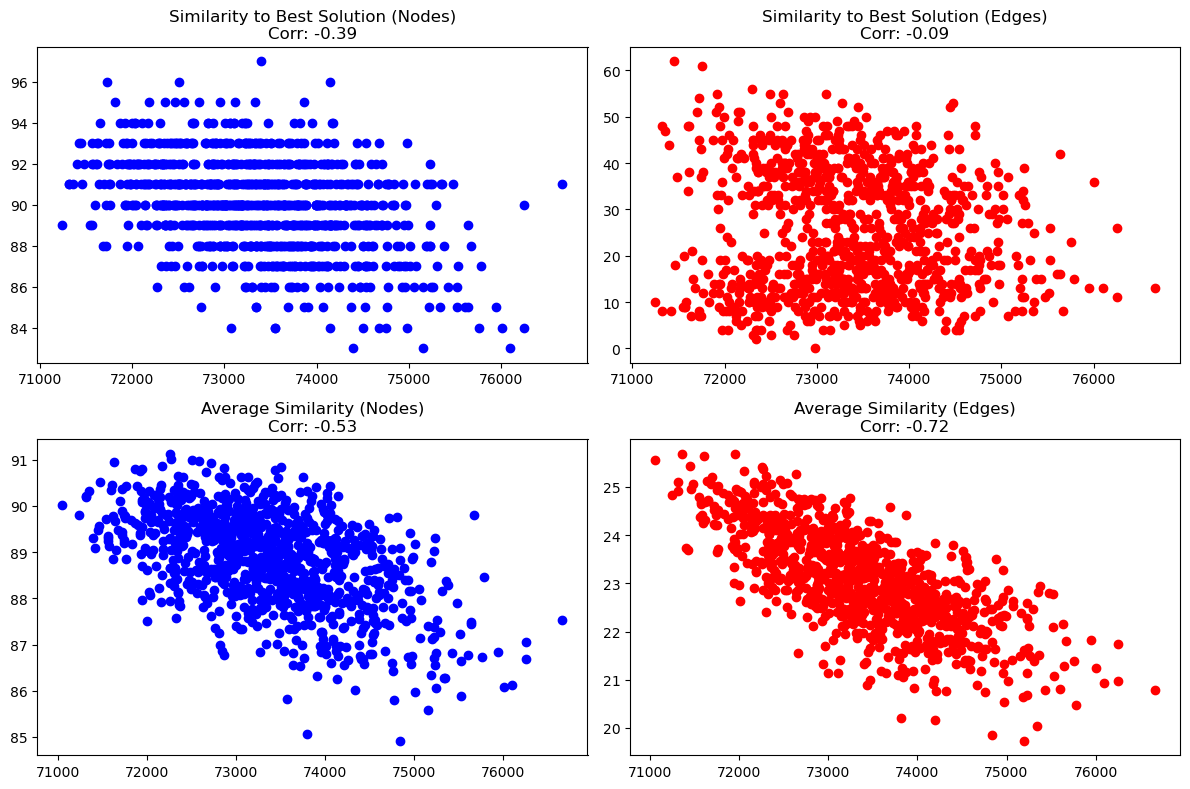

In [7]:
plot_correlations(*calculate_correlations(tsp_a, tsp_a_solutions))

## Instance B


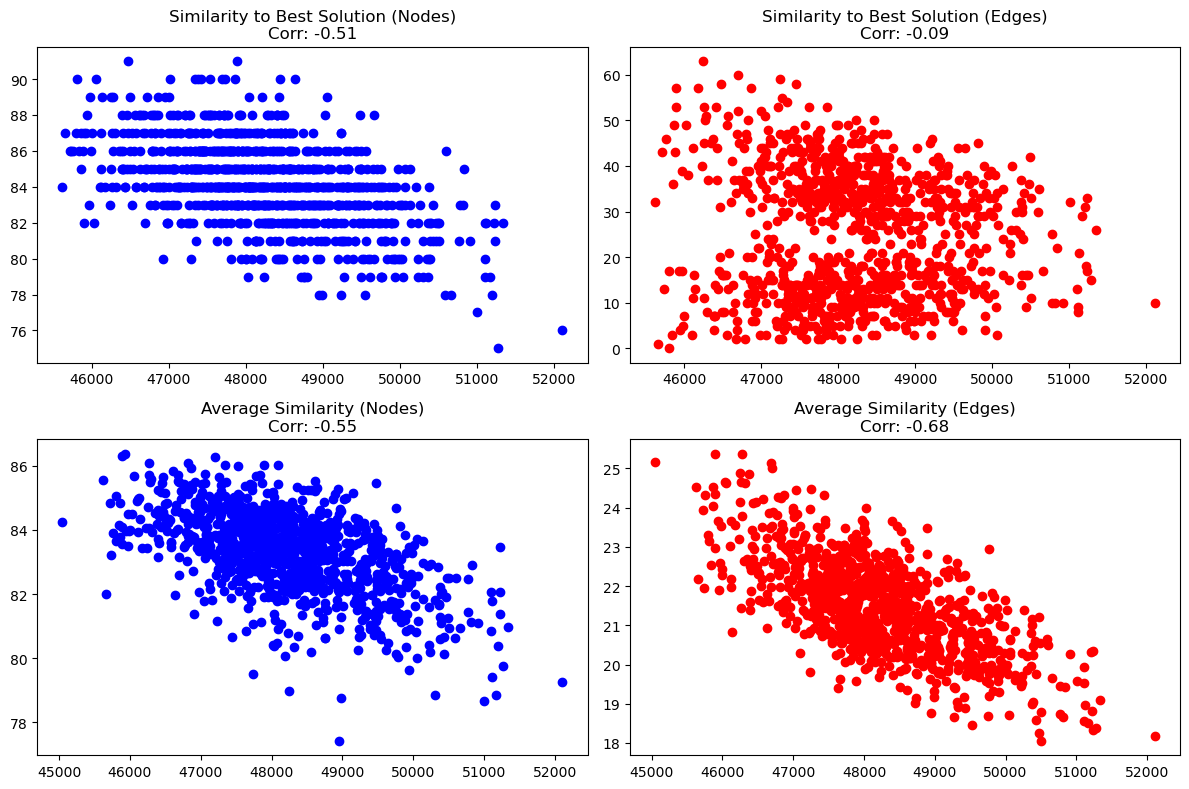

In [8]:
plot_correlations(*calculate_correlations(tsp_b, tsp_b_solutions))

## Conclusions

- In general, as the solution cost decreases, the similarities between solutions increase
- Edge similarity has more variation than node similarity, showing that how the edges are arranged affects the cost more than which exact nodes are chosen
- While good enough solutions lie close to each other, the best ones are not necessarily the most similar ones in terms of both metrics
- Similarity to Best Solution (Edges) shows that there is divergence between the very best solutions